# Optimizing Load Forecasting in Energy: Analysis of Regression Models

### Data Outlook
In this project, we will use the data from SCE. SCE is a power utilities participant in the California deregulated energy market, meaning that everyday SCE buys and sells energy in the market in order to meet the demand of its customers. Most of the forecasted load is bought 14 hours before the start of the “flow date” in the “day-ahead” energy market.

The flow date is defined as the day the energy is consumed by the customers. The rest of the load is bought
in the “real time” energy market in order to hit real time fluxes of demand.

The dataset "sce.csv" file contains the load (measured in MWhs) in hour intervals for every day from 2014 to 2019.
We will build out the function the MAPE (Mean Absolute Precentage Error) for prediction.
### Enviroment Setup and Data Exploration
Let's start with importing the necessary libaries, reading in the data, and getting familar with the dataset.

In [2]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import data
df = pd.read_csv('sce.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['hour'] = df['Date'].dt.hour
df['dayofweek'] = df['Date'].dt.weekday
df.dtypes


/var/folders/kr/g1b22h0d3czf6ck3xxrbt0180000gn/T/ipykernel_52973/14623692.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Date         datetime64[ns]
Load                float64
temp                float64
year                  int32
month                 int32
day                   int32
hour                  int32
dayofweek             int32
dtype: object

In [3]:
df['month'] = df['month'].astype(object)
df['day'] = df['day'].astype(object)
df['hour'] = df['hour'].astype(object)
df['dayofweek'] = df['dayofweek'].astype(object)
df.dtypes
df.set_index('Date',inplace = True)
df[:5]

,Load,temp,year,month,day,hour,dayofweek
Date,,,,,,,
2014-01-01 00:00:00,9891.0,59.4685,2014,1,1,0,2
2014-01-01 01:00:00,9553.0,61.4030,2014,1,1,1,2
2014-01-01 02:00:00,9222.0,55.0310,2014,1,1,2,2
2014-01-01 03:00:00,9024.0,53.1878,2014,1,1,3,2
2014-01-01 04:00:00,8987.0,51.9944,2014,1,1,4,2


In [4]:
def mean_absolute_percentage_error(y,y_pred): 
    y  = np.array(y)
    y_pred = np.array(y_pred)
    return 100*np.mean(np.abs((y-y_pred)/y))

### Test Set and Train Set spilt

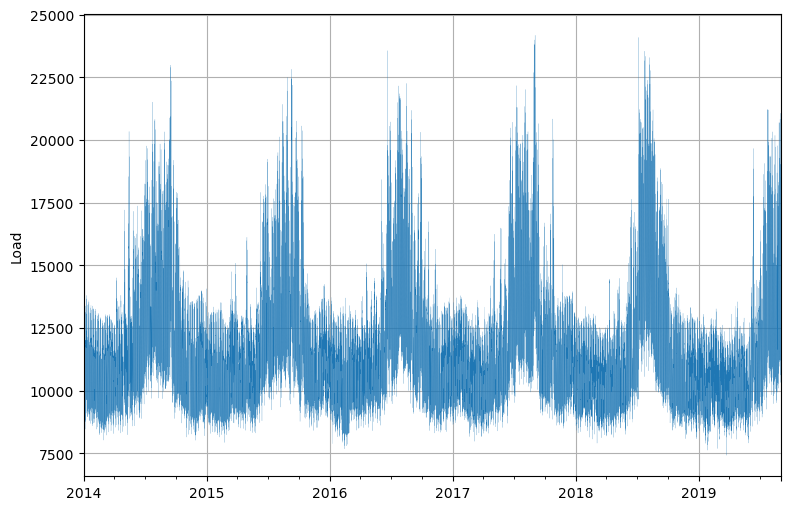

In [23]:
test_set = df[df.year == 2019].copy()

df['Load'].plot(figsize = (9,6),lw=0.1)
plt.ylabel('Load')
plt.xlabel('')
plt.grid();

### Methodology
**Multiple Regression Model(MLR):**
A multiple regression approach is employed to forecast the load. The model includes categorical predictors: month, day, hour, and day of the week. The year is also used as a predictor but not temperature data.

**Exclusion of Temperature Data:**
Temperature data, often a significant predictor in load forecasting, is deliberately excluded from this model to assess the predictive power of the temporal variables alone.

**Model Training:** The model is trained on historical load data along with the mentioned predictors.

### Model 1 with basic temporal predictors

In [6]:
y = df['Load']
m1 = smf.ols(formula = 'Load ~ year + month + day + hour + dayofweek',
             data=df).fit()
m1.summary()
print("R-squared:",m1.rsquared)

R-squared: 0.7308342402827879


In [7]:
yhat = m1.predict(df)
df1_mape = mean_absolute_percentage_error(y,yhat)
print("MAPE:",df1_mape)

MAPE: 8.069690608004327


**Time-Order Preservation:** Instead of using a random train-test split, the data will be split manually to preserve the chronological order. This is essential for capturing the temporal dynamics in load forecasting.

[10862.78588563 10986.49236613 10672.79087478 ... 15427.94332877
 15480.27186242 15315.01480508]


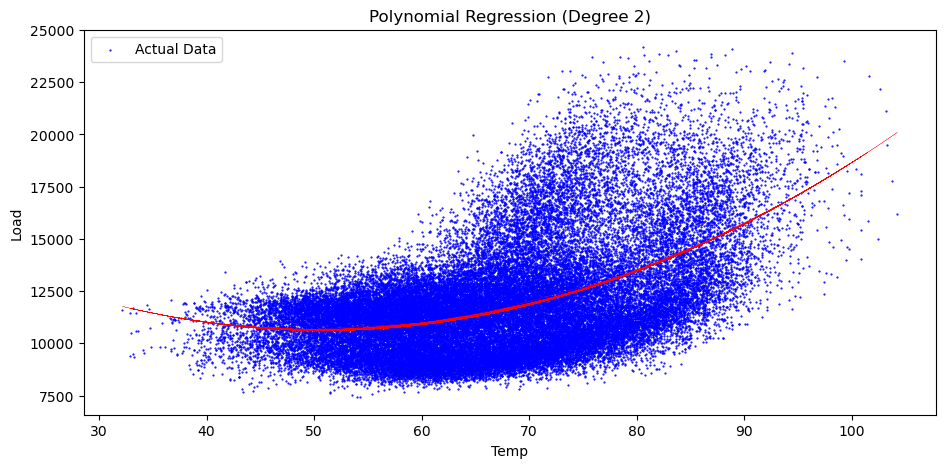

In [8]:
poly = PolynomialFeatures(degree=2)
X = df['temp']
X = X.values.reshape(-1, 1)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, df['Load'])

poly_reg = LinearRegression()
poly_reg.fit(X_poly, df['Load'])
y_pred = poly_reg.predict(X_poly)
print(y_pred)

plt.figure(figsize = (11,5))
plt.scatter(X, df['Load'], color='blue', label='Actual Data',s=0.3)
plt.plot(X, y_pred, color='r',lw=0.2)
plt.xlabel('Temp')
plt.ylabel('Load')
plt.legend()
plt.title('Polynomial Regression (Degree 2)')
plt.show()

### Model 2 with additional predictors:
* *Temperature (Temp)*: Adding temperature as a linear predictor.
* *Squared Temperature (Temp^2*): Incorporating the square of the temperature to capture any non-linear effects.
* *Interaction of Temperature and Hour (Temp * Hour)*: This interaction term aims to understand how the impact of temperature on load varies across different hours of the day.
* *Interaction of Squared Temperature and Hour*: Further explores the non-linear relationship between temperature, time of day, and load.
* *Polynomial Features (Degree 2)*: The model will include polynomial terms (up to degree 2) for the temperature variable. This approach is expected to provide a more nuanced understanding of how temperature variations influence load.

**Model Fitting and Training:**

The second model will be trained on the same dataset as the initial model, with the inclusion of the new temperature-related predictors.
Polynomial features and interaction terms will be carefully crafted and included in the regression model

In [9]:
df['temp2'] = df['temp']**2

m2 = smf.ols(formula = 'Load ~ year + month + day +\
                        dayofweek + temp*hour + temp2*hour',
             data=df).fit()
m2.summary()
print("R-squared:",m2.rsquared)

R-squared: 0.898512660589321


In [10]:
yhat = m2.predict(df)
df2_mape = mean_absolute_percentage_error(y,yhat)
print("MAPE:",df2_mape)

MAPE: 5.171918662670789


### Model 3 with lag24:

The feature **'lag24'** is created by shifting the 'Load' variable by 24 hours. This represents the load value from the previous day, hypothesized to be a predictor for the current day's load. 
The inclusion of this lagged feature is expected to encapsulate the 24-hour cyclical patterns in electricity load.

After introducing the lagged variable, the dataset will contain NA values for the initial 24 hours due to the shift operation. This ensures that the model is trained on complete cases without missing values.

**Model Training with Enhanced Dataset**

The third multiple linear regression (MLR) model will be trained on the dataset, now augmented with the lagged load predictor, in addition to the previous temperature-based predictors and interactions.

This model is expected to provide insights into how past load values influence future load predictions, a critical aspect for SCE's load forecasting.

In [11]:
df['lag24'] = df['Load'].shift(24)
df3 = df.copy()
df3.dropna(inplace = True)
y = df3['Load']

m3 = smf.ols(formula = 'Load ~ year + month + day + hour + lag24+\
                        dayofweek + temp*hour + temp2*hour', data=df3).fit()
m3.summary()
print("R-squared:",m3.rsquared)

R-squared: 0.9409536275105141


In [12]:
yhat = m3.predict(df3)
df3_mape = mean_absolute_percentage_error(y,yhat)
print("MAPE:",df3_mape)

MAPE: 3.843793964347132


### Model 4 with additional lags (PACF time series)

**Partial Autocorrelation Function (PACF) Analysis**
* *PACF Plotting:* A partial autocorrelation plot will be generated for up to 99 lags. This plot reveals the degree of correlation between the load and its lagged values, removing the effects of intermediate lags.
* *Identifying Significant Lags:* Lags that show large partial autocorrelations are potential predictors. These significant lags suggest points in time where past load values have a notable influence on future values, independent of the values at intervening times.

 Based on the PACF analysis, specific lags with significant autocorrelation will be selected as additional predictors for the MLR model.

These new lagged predictors will be added to the existing model . This approach aims to leverage both the short-term and long-term temporal dependencies in the load data.


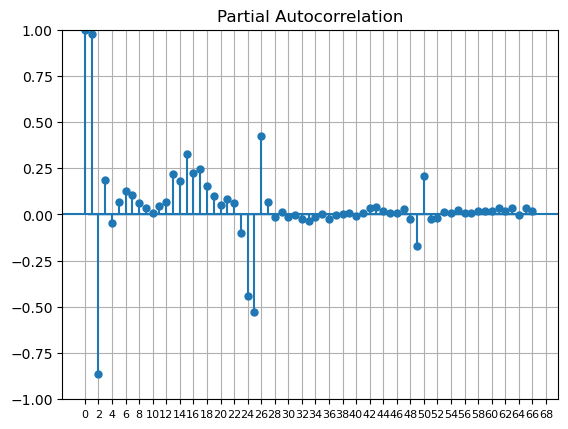

In [13]:
plt.rc("figure") 
sm.graphics.tsa.plot_pacf(df['Load'], lags = 66)
plt.grid()
list1 = [i for i in range(0,70,2)]
plt.xticks(list1,rotation = 0)
plt.tick_params(axis='x', which='major', labelsize=8);

In [14]:
sm.tsa.stattools.pacf(df['Load'],64)

array([ 1.00000000e+00,  9.77780474e-01, -8.61710819e-01,  1.91056492e-01,
       -4.84537147e-02,  6.77623510e-02,  1.25713833e-01,  1.05125233e-01,
        6.09328785e-02,  3.40933527e-02,  6.11745936e-03,  4.48388239e-02,
        6.62012133e-02,  2.22278674e-01,  1.81324035e-01,  3.28123626e-01,
        2.25072661e-01,  2.46079768e-01,  1.54228556e-01,  9.88795553e-02,
        5.11906269e-02,  8.55473928e-02,  6.24905987e-02, -1.00411593e-01,
       -4.44813943e-01, -5.31676835e-01,  4.33288533e-01,  6.10674359e-02,
       -1.22169923e-02,  1.47887802e-02, -1.33108242e-02, -4.11144046e-03,
       -2.55738280e-02, -3.30278061e-02, -1.30651339e-02,  1.85653454e-03,
       -2.37500278e-02, -4.73874240e-03,  4.48957350e-03,  9.44913577e-03,
       -9.94067949e-03,  6.19093730e-03,  3.80404467e-02,  4.29441362e-02,
        1.63678295e-02,  8.23338091e-03,  5.55602825e-03,  3.08273472e-02,
       -2.47032149e-02, -1.70109846e-01,  2.09895612e-01, -2.88795439e-02,
       -2.08831231e-02,  

In [15]:
df['lag15'] = df['Load'].shift(15)
df6 = df.copy()
df6.dropna(inplace = True)
df6['lag15'] = df6['lag15'].astype('int')
df6['lag24'] = df6['lag24'].astype('int')

m6 = smf.ols(formula = 'Load ~ year + month + day + hour +\
                                lag24 + lag15 +\
                        dayofweek + temp*hour + temp2*hour',data=df6).fit()
m6.summary()
print("R-squared:",m6.rsquared)
y = df6['Load']
yhat = m6.predict(df6)
df3_mape = mean_absolute_percentage_error(y,yhat)
print("MAPE:",df3_mape)

R-squared: 0.9420231497287591
MAPE: 3.845163541269488


### Model Evaluation and Prediction

**R-Squared:** The train R-squared will be reported for the enhanced model to assess its explanatory power compared to the initial model.

**Mean Absolute Percentage Error (MAPE):** MAPE remains a critical metric, especially to evaluate how the inclusion of temperature and its interactions affect the model's predictive accuracy.

The best-performing model: Model 4 is used to predict the Load on the test set (data from the year 2019). This step is crucial as it evaluates the model's performance in a real-world scenario, outside of the training data environment.

In [25]:
test_set2 = test_set.copy()
test_set2['temp2'] = test_set2['temp']**2
test_set2['lag24'] = test_set2['Load'].shift(24)
test_set2['lag15'] = test_set2['Load'].shift(15)
test_set2['lag7'] = test_set2['Load'].shift(24*7)
test_set2.dropna(inplace = True)

test_set2['lag24'] = test_set2['lag24'].astype(int)
test_set2['lag15'] = test_set2['lag15'].astype(int)
test_set2['lag7'] = test_set2['lag7'].astype(int)
test_set2[:5].style.hide(axis='index')

Load,temp,year,month,day,hour,dayofweek,temp2,lag24,lag15,lag7
9626.000000,60.102500,2019,1,8,0,1,3612.310506,9139,11419,9761
9247.000000,59.358000,2019,1,8,1,1,3523.372164,8809,11203,9438
9042.000000,57.387000,2019,1,8,2,1,3293.267769,8676,11026,9177
9026.000000,54.140000,2019,1,8,3,1,2931.139600,8696,10945,9024
9340.000000,53.240500,2019,1,8,4,1,2834.550840,9046,10936,9015


In [28]:
y_test = test_set2['Load']
yhat = m6.predict(test_set2)
df7_mape = mean_absolute_percentage_error(y_test,yhat)
print("MAPE:",df7_mape)

MAPE: 4.029153724367321


In [29]:
#MAE for the test set
test_sse = sum((y_test - yhat)**2)
test_sstot = sum((y_test - np.mean(y_test))**2)
1 - test_sse/test_sstot

0.9405554521233603

### Visualization: Scatterplot of Load vs. Predicted Load

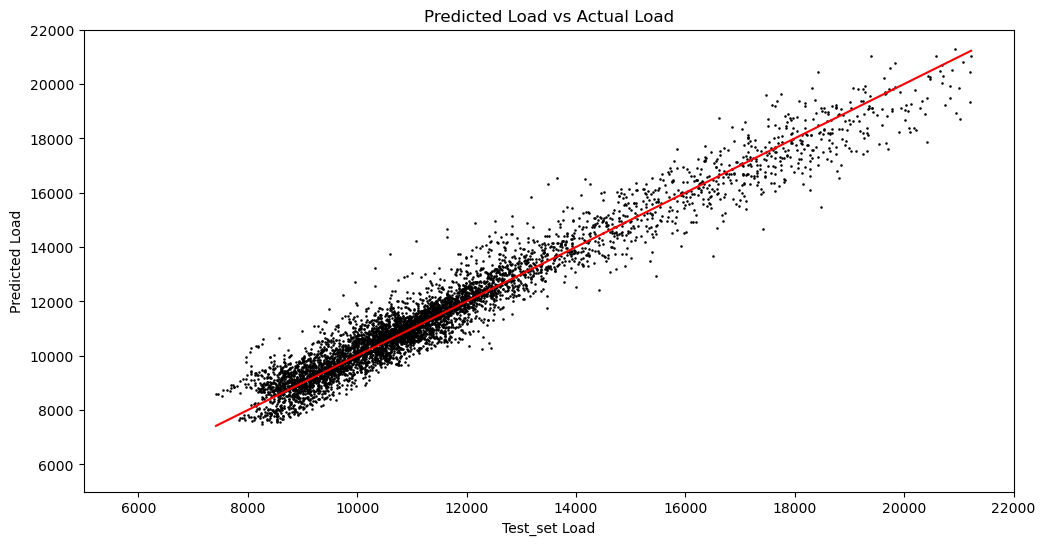

In [31]:
xval = np.linspace(min(test_set2['Load']),max(test_set2['Load']),100)
yval = xval
plt.figure(figsize = (12,6))
plt.scatter(test_set2['Load'],yhat, color = 'k',s=0.7)
plt.plot(xval, yval, color = 'r')
plt.xlim(5000,22000)
plt.ylim(5000,22000)
plt.xlabel('Test_set Load')
plt.ylabel('Predicted Load')
plt.title('Predicted Load vs Actual Load')
plt.show()

The comparative analysis of the four developed models highlighted key insights into the importance of feature selection and model complexity in time series forecasting. The best-performing model struck an optimal balance between capturing intricate patterns in the data and avoiding overfitting, thus providing a robust tool for accurate load forecasting. This model, with its carefully chosen set of predictors and validated performance metrics, represents the culmination of the project's methodical approach to enhancing predictive accuracy in load forecasting.